In [1]:
from Data import *

import pandas as pd
import string
import random

import torch
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils.rnn import  pack_padded_sequence, pad_packed_sequence
from torchsummary import summary

import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import numpy as np
import tqdm
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_name = 'Lab4_seq2seq_vae_gru_KL_cond.pt'
loss_file = 'Lab4_seq2seq_vae_gru_KL_cond_loss.npz'
print('Using {} device'.format(device))

Using cuda device


In [2]:
sp = 0
tp = 1
pg = 2
p = 3

def split_data(data):
    split_data = []
    for string in data:
        split_space = string.split()
        for i, word in enumerate(split_space):
            split_data.append(word)
    return split_data

def y_train_make(n):
    np_sp = np.array([sp])
    np_tp = np.array([tp])
    np_pg = np.array([pg])
    np_p = np.array([p])
    y = []
    for i in range(n):
        y.append(np_sp)
        y.append(np_tp)
        y.append(np_pg)
        y.append(np_p)
    return np.array(y)

def src_trg_split(data):
    src = []
    trg = []
    for i in range(0, len(data), 2):
        src.append(data[i])
        trg.append(data[i+1])
    return np.array(src), np.array(trg)

In [3]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_data = np.squeeze(pd.read_csv('train.txt', header=None))

y_train = y_train_make(len(train_data))

def to_one_hot(label):
    one_hot =  np.zeros((len(label), 4))
    one_hot[np.arange(len(label)), label[:, 0]] = 1
    return one_hot
    
y_train = to_one_hot(y_train)
train_data = split_data(train_data)
train_loader = DataTransformer(train_data, y_train, use_cuda=True)

In [4]:
test_data = np.squeeze(pd.read_csv('test.txt', header=None))
test_data = split_data(test_data)
test_data = np.array(test_data)
src, trg = src_trg_split(test_data)
test_src = []
test_trg = []

for word in src:
    test_src.append(train_loader.vocab.sequence_to_indices(word, add_eos=True))

for word in trg:
    test_trg.append(train_loader.vocab.sequence_to_indices(word, add_eos=True))
"""
sp -> p
sp -> pg
sp -> tp
sp -> tp
p  -> tp
sp -> pg
p  -> sp
pg -> sp
pg -> p
pg -> tp
"""
test_c_src = np.array([sp, sp, sp, sp, p, sp, p, pg, pg, pg]).reshape(-1, 1)
test_c_trg = np.array([p, pg, tp, tp, tp, pg, sp, sp, p, tp]).reshape(-1, 1)
test_c_src = Variable(torch.LongTensor(to_one_hot(test_c_src))).to(device)
test_c_trg = Variable(torch.LongTensor(to_one_hot(test_c_trg))).to(device)

In [5]:
def test_eval(model, epoch):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():    
        src_c = test_src
        trg_c = test_trg
        optimizer.zero_grad()            
        output = model(src, trg, src_c, trg_c, 0) #turn off teacher forcing
        loss = criterion(output[1:].view(-1, output.shape[-1]), trg[1:].view(-1))
        
        if epoch % 10 == 0:
            print("=========show testing result=========")
            for i in range(output.shape[-1]):
                show_result(trg, output, i)
                print()
            
        return loss
    
def show_result(target, output, index):
    print("Ground true: ", end="")
    for i in range(max_len):
        tmp = trg[index, i]
        if tmp == 1:
            break
        elif tmp == 0:
            continue
        print(chr(trg[index, i]-7+ord('a')), end="")
    
    print(" Predict: ", end="")
    for i in range(max_len):
        print(chr(np.argmax(o[index, i, 3:])-4+ord('a')), end="")

In [6]:
class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_size, output_size, lat_dim):
        """Define layers for a vanilla rnn encoder"""
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, output_size)
        
        self.hidden2mean = nn.Linear(output_size, lat_dim)
        self.hidden2logv = nn.Linear(output_size, lat_dim)

    def forward(self, input_seqs, input_lengths, label, hidden=None):
        embedded = self.embedding(input_seqs)
        packed = pack_padded_sequence(embedded, input_lengths)
        label = label.view(1, label.shape[0], label.shape[1])
        hidden = torch.cat([hidden, label], dim=2)
        packed_outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = pad_packed_sequence(packed_outputs)
        
        means = self.hidden2mean(hidden)
        logv = self.hidden2logv(hidden)
        
        return outputs, means, logv
    
    def initHidden(self, batch_size):
        return torch.zeros([1, batch_size, 256-4]) # (D * num_layers, batch_size, H_out) 

In [7]:
class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size, lat_dim, max_length, teacher_forcing_ratio, sos_id, use_cuda):
        """Define layers for a vanilla rnn decoder"""
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.latent2hidden = nn.Linear(lat_dim, hidden_size-4)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=-1)  # work with NLLLoss = CrossEntropyLoss

        self.max_length = max_length
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.sos_id = sos_id
        self.use_cuda = use_cuda

    def forward_step(self, inputs, hidden):
        # inputs: (time_steps=1, batch_size)
        batch_size = inputs.size(1)
        embedded = self.embedding(inputs)
        embedded.view(1, batch_size, self.hidden_size)  # S = T(1) x B x N
        rnn_output, hidden = self.gru(embedded, hidden)  # S = T(1) x B x H
        rnn_output = rnn_output.squeeze(0)  # squeeze the time dimension
        output = self.log_softmax(self.out(rnn_output))  # S = B x O
        return output, hidden

    def forward(self, context_vector, targets):

        # Prepare variable for decoder on time_step_0
        target_vars, target_lengths = targets
        batch_size = context_vector.size(1)
        decoder_input = Variable(torch.LongTensor([[self.sos_id] * batch_size]))

        # Pass the context vector
        decoder_hidden = context_vector

        max_target_length = max(target_lengths)
        decoder_outputs = Variable(torch.zeros(
            max_target_length,
            batch_size,
            self.output_size
        ))  # (time_steps, batch_size, vocab_size)

        if self.use_cuda:
            decoder_input = decoder_input.cuda()
            decoder_outputs = decoder_outputs.cuda()

        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False

        # Unfold the decoder RNN on the time dimension
        for t in range(max_target_length):
            decoder_outputs_on_t, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs[t] = decoder_outputs_on_t
            if use_teacher_forcing:
                decoder_input = target_vars[t].unsqueeze(0)
            else:
                decoder_input = self._decode_to_index(decoder_outputs_on_t)

        return decoder_outputs, decoder_hidden

    def evaluate(self, context_vector):
        batch_size = context_vector.size(1) # get the batch size
        decoder_input = Variable(torch.LongTensor([[self.sos_id] * batch_size]))
        decoder_hidden = context_vector

        decoder_outputs = Variable(torch.zeros(
            self.max_length,
            batch_size,
            self.output_size
        ))  # (time_steps, batch_size, vocab_size)

        if self.use_cuda:
            decoder_input = decoder_input.cuda()
            decoder_outputs = decoder_outputs.cuda()

        # Unfold the decoder RNN on the time dimension
        for t in range(self.max_length):
            decoder_outputs_on_t, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs[t] = decoder_outputs_on_t
            decoder_input = self._decode_to_index(decoder_outputs_on_t)  # select the former output as input

        return self._decode_to_indices(decoder_outputs)

    def _decode_to_index(self, decoder_output):
        """
        evaluate on the logits, get the index of top1
        :param decoder_output: S = B x V or T x V
        """
        value, index = torch.topk(decoder_output, 1)
        index = index.transpose(0, 1)  # S = 1 x B, 1 is the index of top1 class
        if self.use_cuda:
            index = index.cuda()
        return index

    def _decode_to_indices(self, decoder_outputs):
        """
        Evaluate on the decoder outputs(logits), find the top 1 indices.
        Please confirm that the model is on evaluation mode if dropout/batch_norm layers have been added
        :param decoder_outputs: the output sequence from decoder, shape = T x B x V 
        """
        decoded_indices = []
        batch_size = decoder_outputs.size(1)
        decoder_outputs = decoder_outputs.transpose(0, 1)  # S = B x T x V

        for b in range(batch_size):
            top_ids = self._decode_to_index(decoder_outputs[b])
            decoded_indices.append(top_ids.data[0].cpu().numpy())
        return decoded_indices

In [8]:
class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, inputs, targets, label):
        # variables
        input_vars, input_lengths = inputs
        batch_size = input_vars.shape[1]
        encoder_hidden = self.encoder.initHidden(batch_size).to(device)
        # nn
        encoder_outputs, encoder_means, encoder_logv = self.encoder.forward(input_vars, input_lengths, label, hidden=encoder_hidden)       
        encoder_hidden = self.reparaterization_trick(encoder_means, encoder_logv)
        encoder_hidden = self.decoder.latent2hidden(encoder_hidden)
        encoder_hidden = torch.cat([encoder_hidden, label.view(1, label.shape[0], label.shape[1])], dim=2)
        decoder_outputs, decoder_hidden = self.decoder.forward(context_vector=encoder_hidden, targets=targets)
        return decoder_outputs, decoder_hidden, encoder_means, encoder_logv

    def evaluate(self, inputs, src_label, trg_label):
        # variables
        input_vars, input_lengths = inputs
        batch_size = input_vars.shape[1]
        encoder_hidden = self.encoder.initHidden(batch_size).to(device)

        # nn 
        encoder_outputs, encoder_means, encoder_logv = self.encoder(input_vars, input_lengths, src_label, hidden=encoder_hidden)
        encoder_hidden = self.reparaterization_trick(encoder_means, encoder_logv)
        encoder_hidden = self.decoder.latent2hidden(encoder_hidden)
        encoder_hidden = torch.cat([encoder_hidden, trg_label.view(1, trg_label.shape[0], trg_label.shape[1])], dim=2)
        decoded_sentence = self.decoder.evaluate(context_vector=encoder_hidden)
        return decoded_sentence
    
    def reparaterization_trick(self, mean, logv):
        std = torch.exp(0.5*logv)
        eps = torch.randn_like(std)
        return  mean + eps * std

In [9]:
class Trainer(object):

    def __init__(self, model, data_transformer, label, learning_rate, use_cuda, checkpoint_name,
                 teacher_forcing_ratio=1.0, kl_weight=0):

        self.model = model
        self.checkpoint_name = checkpoint_name
        self.total_iter = 0
        
        # save list
        self.entropy = []
        self.kld = []
        self.kl_weight_list = []
        self.teacher_forcing_ratio_list = []
        self.score = []
        
        # init hyperparameters
        self.kl_weight = kl_weight
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.kl_weight_list.append(self.kl_weight)
        self.teacher_forcing_ratio_list.append(self.teacher_forcing_ratio)
        
        # record some information about dataset
        self.data_transformer = data_transformer
        self.label = label
        self.vocab_size = self.data_transformer.vocab_size
        self.PAD_ID = self.data_transformer.PAD_ID
        self.use_cuda = use_cuda
        
        # optimizer setting
        self.learning_rate = learning_rate
        self.optimizer= torch.optim.Adam(self.model.parameters(), lr=learning_rate)
#         self.optimizer= torch.optim.SGD(self.model.parameters(), lr=learning_rate)
        self.criterion = torch.nn.NLLLoss(ignore_index=self.PAD_ID, reduction='mean')

    def train(self, num_epochs, batch_size, pretrained=False):

        if pretrained:
            self.load_model()

        step = 0

        for epoch in range(0, num_epochs):
            mini_batches = self.data_transformer.mini_batches(batch_size=batch_size)
            for input_batch, target_batch, label_batch in mini_batches:
                self.total_iter += 1
                self.optimizer.zero_grad()
                self.model.decoder.teacher_forcing_ratio = self.teacher_forcing_ratio
                decoder_outputs, decoder_hidden, encoder_means, encoder_logv = self.model(input_batch, target_batch, label_batch)

                # calculate the loss and back prop.
                cur_loss = self.get_loss(decoder_outputs, target_batch[0])
                kl_loss = self.kl_weight * self.get_kl_loss(encoder_means, encoder_logv)
                loss = cur_loss + kl_loss
                
                self.entropy.append(cur_loss.item())
                self.kld.append(kl_loss.item())
                
                # logging
                step += 1
                if step % 50 == 0:
                    print("Step:", step, "char-loss: ", loss.item())
                    print("KL_weight: ", self.kl_weight, "teacher_forcing_ratio: ", self.teacher_forcing_ratio)
                    self.save_model()
                loss.backward()

                # optimize
                self.optimizer.step()
                
                # update hyperparameters
                self.kl_weight = self.get_kl_weight(self.kl_weight)
                self.teacher_forcing_ratio = self.get_teacher_forcing_ratio(self.teacher_forcing_ratio)
                self.kl_weight_list.append(self.kl_weight)
                self.teacher_forcing_ratio_list.append(self.teacher_forcing_ratio)

        self.save_model()

    def get_loss(self, decoder_outputs, targets):
        b = decoder_outputs.size(1)
        t = decoder_outputs.size(0)
        targets = targets.contiguous().view(-1)  # S = (B*T)
        decoder_outputs = decoder_outputs.view(b * t, -1)  # S = (B*T) x V
        return self.criterion(decoder_outputs, targets)
    
    def get_kl_loss(self, mean, logvar):
        result = -0.5 * torch.sum(logvar - torch.pow(mean, 2) - torch.exp(logvar) + 1, 1)
        return result.mean()
    
    def get_kl_weight(self, kl_weight):
#         if self.total_iter < 100000:
#             return 0
#         else:
#             return min(1, kl_weight + 0.00001)
        return min(1, kl_weight + 0.0000001)

    def get_teacher_forcing_ratio(self, teacher_forcing_ratio):
#         if self.total_iter < 10000:
#             return 1.0
#         else:
        return max(0, teacher_forcing_ratio - 0.0000001)
#         return 1

    def save_model(self):
        torch.save(self.model.state_dict(), self.checkpoint_name)
        np.savez(loss_file, entropy=self.entropy, kld=self.kld, kl_weight=self.kl_weight_list,\
                 teacher_forcing_ratio=self.teacher_forcing_ratio_list, score=self.score)
        print("Model has been saved as %s.\n" % self.checkpoint_name)

    def load_model(self):
        self.model.load_state_dict(torch.load(self.checkpoint_name, map_location=device))
        print("Pretrained model has been loaded.\n")

    def evaluate(self, words, src_label, trg_label):
        # make sure that words is list
        if type(words) is not list:
            words = [words]

        # transform word to index-sequence
        eval_var = self.data_transformer.evaluation_batch(words=words)
        decoded_indices = self.model.evaluate(eval_var, src_label, trg_label)
        results = []
        for indices in decoded_indices:
            results.append(self.data_transformer.vocab.indices_to_sequence(indices))
        return results
    
    def compute_bleu(self, output, reference):
        cc = SmoothingFunction()
        if len(reference) == 3:
            weights = (0.33,0.33,0.33)
        else:
            weights = (0.25,0.25,0.25,0.25)
        return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

In [10]:
# define our models
encoder = Encoder(vocab_size=train_loader.vocab_size,
                         embedding_size=256,
                         output_size=256,
                         lat_dim=32).to(device)

decoder = Decoder(hidden_size=256,
                         output_size=train_loader.vocab_size,
                         lat_dim=32,
                         max_length=train_loader.max_length,
                         teacher_forcing_ratio=1.,
                         sos_id=train_loader.SOS_ID,
                         use_cuda=True).to(device)

seq2seq = Seq2Seq(encoder=encoder,
                  decoder=decoder)

In [11]:
trainer = Trainer(seq2seq, train_loader, y_train, learning_rate=0.001, use_cuda=True, checkpoint_name=checkpoint_name)

for epoch in tqdm.notebook.tqdm(range(200)):
    trainer.train(num_epochs=10, batch_size=128, pretrained=False)
    
    ## eval
    print("========================================Evaluating========================================")  
    total_score = 0.0
    for i in range(len(test_src)):
        word = train_loader.vocab.indices_to_sequence(test_src[i])
        trg_true = train_loader.vocab.indices_to_sequence(test_trg[i])
        results = trainer.evaluate(word, test_c_src[i].view(1, -1), test_c_trg[i].view(1, -1))[0]
        score = trainer.compute_bleu(results, trg_true)
        print("Src_true: {:>12}".format(word), "\tTrg_true:{:>12}".format(trg_true), "\tPredict: {:>12}".format(results), "\tScore: {:>8.5f}".format(score))
        total_score += score
    total_score /= len(test_src)
    trainer.score.append(total_score)
    print("==========================================================================================\n")

Step: 50 char-loss:  1.82120680809021
KL_weight:  4.899999999999996e-06 teacher_forcing_ratio:  0.9999951000000026
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  1.2297435998916626
KL_weight:  9.90000000000001e-06 teacher_forcing_ratio:  0.9999901000000052
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.7674343585968018
KL_weight:  1.4900000000000047e-05 teacher_forcing_ratio:  0.9999851000000078
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.5293326377868652
KL_weight:  1.9900000000000006e-05 teacher_forcing_ratio:  0.9999801000000105
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.3887477219104767
KL_weight:  2.4899999999999958e-05 teacher_forcing_ratio:  0.9999751000000131
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.2526876926422119
KL_weight:  2.989999999999991e-05 teacher_forcing_ratio:  0.9999701000000157
Mod

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict: abonardualed 	Score:  0.06704
Src_true:         abet 	Trg_true:    abetting 	Predict:  batembating 	Score:  0.27902
Src_true:        begin 	Trg_true:      begins 	Predict:   begulanine 	Score:  0.13135
Src_true:       expend 	Trg_true:     expends 	Predict: expenderateding 	Score:  0.32377
Src_true:         sent 	Trg_true:       sends 	Predict:   snettersun 	Score:  0.02985
Src_true:        split 	Trg_true:   splitting 	Predict:  splurtilish 	Score:  0.13194
Src_true:       flared 	Trg_true:       flare 	Predict: flarourezedes 	Score:  0.21973
Src_true:  functioning 	Trg_true:    function 	Predict: funchountinying 	Score:  0.21024
Src_true:  functioning 	Trg_true:  functioned 	Predict: funchountirying 	Score:  0.21024
Src_true:      healing 	Trg_true:       heals 	Predict:  helabinate

Step: 100 char-loss:  0.07457250356674194
KL_weight:  0.000282900000000006 teacher_forcing_ratio:  0.9997171000001489
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.07448713481426239
KL_weight:  0.00028790000000000613 teacher_forcing_ratio:  0.9997121000001515
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.07151507586240768
KL_weight:  0.00029290000000000625 teacher_forcing_ratio:  0.9997071000001542
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.07865010201931
KL_weight:  0.0002979000000000064 teacher_forcing_ratio:  0.9997021000001568
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.08116204291582108
KL_weight:  0.0003029000000000065 teacher_forcing_ratio:  0.9996971000001594
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.07951149344444275
KL_weight:  0.0003079000000000066 teacher_forcing_ratio:  0.999692100000162

Step: 50 char-loss:  0.08080457150936127
KL_weight:  0.0004339000000000097 teacher_forcing_ratio:  0.9995661000002284
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.08893631398677826
KL_weight:  0.0004389000000000098 teacher_forcing_ratio:  0.999561100000231
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.08986815065145493
KL_weight:  0.0004439000000000099 teacher_forcing_ratio:  0.9995561000002336
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.08485480397939682
KL_weight:  0.00044890000000001004 teacher_forcing_ratio:  0.9995511000002363
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.08531933277845383
KL_weight:  0.00045390000000001017 teacher_forcing_ratio:  0.9995461000002389
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.08660055696964264
KL_weight:  0.0004589000000000103 teacher_forcing_ratio:  0.9995411000002

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:  anforamated 	Score:  0.06239
Src_true:         abet 	Trg_true:    abetting 	Predict: abetholizing 	Score:  0.30661
Src_true:        begin 	Trg_true:      begins 	Predict:  befistances 	Score:  0.05013
Src_true:       expend 	Trg_true:     expends 	Predict: expenderates 	Score:  0.43362
Src_true:         sent 	Trg_true:       sends 	Predict:   snetchines 	Score:  0.02985
Src_true:        split 	Trg_true:   splitting 	Predict: splitcholing 	Score:  0.42401
Src_true:       flared 	Trg_true:       flare 	Predict:  flarasheded 	Score:  0.24808
Src_true:  functioning 	Trg_true:    function 	Predict: functionalize 	Score:  0.55937
Src_true:  functioning 	Trg_true:  functioned 	Predict: functionoled 	Score:  0.67042
Src_true:      healing 	Trg_true:       heals 	Predict:   helainales 	Score:

Step: 100 char-loss:  0.08507760614156723
KL_weight:  0.0007118999999998952 teacher_forcing_ratio:  0.9992881000003747
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.09433665871620178
KL_weight:  0.0007168999999998926 teacher_forcing_ratio:  0.9992831000003773
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.08408567309379578
KL_weight:  0.00072189999999989 teacher_forcing_ratio:  0.99927810000038
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.08359101414680481
KL_weight:  0.0007268999999998874 teacher_forcing_ratio:  0.9992731000003826
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.07739502936601639
KL_weight:  0.0007318999999998848 teacher_forcing_ratio:  0.9992681000003852
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.08646751195192337
KL_weight:  0.0007368999999998822 teacher_forcing_ratio:  0.9992631000003879


Step: 50 char-loss:  0.08806897699832916
KL_weight:  0.000862899999999817 teacher_forcing_ratio:  0.9991371000004542
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.09492315351963043
KL_weight:  0.0008678999999998144 teacher_forcing_ratio:  0.9991321000004568
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.08872809261083603
KL_weight:  0.0008728999999998118 teacher_forcing_ratio:  0.9991271000004595
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.09775561839342117
KL_weight:  0.0008778999999998092 teacher_forcing_ratio:  0.9991221000004621
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.09449722617864609
KL_weight:  0.0008828999999998066 teacher_forcing_ratio:  0.9991171000004647
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.09077198058366776
KL_weight:  0.000887899999999804 teacher_forcing_ratio:  0.9991121000004674

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict: bankorolated 	Score:  0.11531
Src_true:         abet 	Trg_true:    abetting 	Predict:     abetting 	Score:  1.00000
Src_true:        begin 	Trg_true:      begins 	Predict:    beginates 	Score:  0.46714
Src_true:       expend 	Trg_true:     expends 	Predict:    empreates 	Score:  0.03391
Src_true:         sent 	Trg_true:       sends 	Predict: snothersinks 	Score:  0.02409
Src_true:        split 	Trg_true:   splitting 	Predict:  splictoring 	Score:  0.35084
Src_true:       flared 	Trg_true:       flare 	Predict:   flaraunted 	Score:  0.27776
Src_true:  functioning 	Trg_true:    function 	Predict:  functioning 	Score:  0.67865
Src_true:  functioning 	Trg_true:  functioned 	Predict: functionized 	Score:  0.67042
Src_true:      healing 	Trg_true:       heals 	Predict:      helaves 	Score: 

Step: 100 char-loss:  0.1003432646393776
KL_weight:  0.0011408999999998513 teacher_forcing_ratio:  0.9988591000006005
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.11122875660657883
KL_weight:  0.0011458999999998541 teacher_forcing_ratio:  0.9988541000006032
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.10389135032892227
KL_weight:  0.001150899999999857 teacher_forcing_ratio:  0.9988491000006058
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.1075424775481224
KL_weight:  0.0011558999999998598 teacher_forcing_ratio:  0.9988441000006084
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.10353457927703857
KL_weight:  0.0011608999999998626 teacher_forcing_ratio:  0.998839100000611
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.10756464302539825
KL_weight:  0.0011658999999998654 teacher_forcing_ratio:  0.9988341000006137


Step: 50 char-loss:  0.11010776460170746
KL_weight:  0.0012918999999999368 teacher_forcing_ratio:  0.99870810000068
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.12276808172464371
KL_weight:  0.0012968999999999396 teacher_forcing_ratio:  0.9987031000006826
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.11946505308151245
KL_weight:  0.0013018999999999425 teacher_forcing_ratio:  0.9986981000006853
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.1160244569182396
KL_weight:  0.0013068999999999453 teacher_forcing_ratio:  0.9986931000006879
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.11428063362836838
KL_weight:  0.0013118999999999481 teacher_forcing_ratio:  0.9986881000006905
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.11637049913406372
KL_weight:  0.001316899999999951 teacher_forcing_ratio:  0.9986831000006932
M

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:   bankrolled 	Score:  0.13747
Src_true:         abet 	Trg_true:    abetting 	Predict:   abettaying 	Score:  0.52538
Src_true:        begin 	Trg_true:      begins 	Predict:      befists 	Score:  0.08307
Src_true:       expend 	Trg_true:     expends 	Predict:  expercesses 	Score:  0.24808
Src_true:         sent 	Trg_true:       sends 	Predict:    stermures 	Score:  0.03156
Src_true:        split 	Trg_true:   splitting 	Predict:  switluching 	Score:  0.12761
Src_true:       flared 	Trg_true:       flare 	Predict:     flarated 	Score:  0.36556
Src_true:  functioning 	Trg_true:    function 	Predict: functionalized 	Score:  0.51424
Src_true:  functioning 	Trg_true:  functioned 	Predict: functionalized 	Score:  0.56220
Src_true:      healing 	Trg_true:       heals 	Predict:      healles 	Sco

Step: 100 char-loss:  0.140364870429039
KL_weight:  0.0015699000000000943 teacher_forcing_ratio:  0.9984301000008263
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.12427045404911041
KL_weight:  0.001574900000000097 teacher_forcing_ratio:  0.998425100000829
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.1276315450668335
KL_weight:  0.0015799000000001 teacher_forcing_ratio:  0.9984201000008316
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.1318168044090271
KL_weight:  0.0015849000000001028 teacher_forcing_ratio:  0.9984151000008342
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.13429725170135498
KL_weight:  0.0015899000000001056 teacher_forcing_ratio:  0.9984101000008369
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.12834858894348145
KL_weight:  0.0015949000000001084 teacher_forcing_ratio:  0.9984051000008395
Model

Step: 50 char-loss:  0.14527076482772827
KL_weight:  0.0017209000000001798 teacher_forcing_ratio:  0.9982791000009058
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.13662119209766388
KL_weight:  0.0017259000000001826 teacher_forcing_ratio:  0.9982741000009084
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.14260245859622955
KL_weight:  0.0017309000000001855 teacher_forcing_ratio:  0.9982691000009111
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.1388564556837082
KL_weight:  0.0017359000000001883 teacher_forcing_ratio:  0.9982641000009137
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.14816279709339142
KL_weight:  0.0017409000000001911 teacher_forcing_ratio:  0.9982591000009163
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.1479760855436325
KL_weight:  0.001745900000000194 teacher_forcing_ratio:  0.998254100000919
M

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:   bankoraged 	Score:  0.14287
Src_true:         abet 	Trg_true:    abetting 	Predict:    abetching 	Score:  0.43167
Src_true:        begin 	Trg_true:      begins 	Predict:      benists 	Score:  0.08784
Src_true:       expend 	Trg_true:     expends 	Predict:  experiences 	Score:  0.27902
Src_true:         sent 	Trg_true:       sends 	Predict:    sentifies 	Score:  0.12753
Src_true:        split 	Trg_true:   splitting 	Predict:   splitching 	Score:  0.52538
Src_true:       flared 	Trg_true:       flare 	Predict:     flarated 	Score:  0.36556
Src_true:  functioning 	Trg_true:    function 	Predict:   functioned 	Score:  0.75984
Src_true:  functioning 	Trg_true:  functioned 	Predict:   functioned 	Score:  1.00000
Src_true:      healing 	Trg_true:       heals 	Predict:     helaxues 	Score: 

Step: 100 char-loss:  0.15570807456970215
KL_weight:  0.001998900000000238 teacher_forcing_ratio:  0.9980011000010521
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.14603769779205322
KL_weight:  0.00200390000000023 teacher_forcing_ratio:  0.9979961000010548
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.15977796912193298
KL_weight:  0.002008900000000222 teacher_forcing_ratio:  0.9979911000010574
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.1499660462141037
KL_weight:  0.002013900000000214 teacher_forcing_ratio:  0.99798610000106
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.15629175305366516
KL_weight:  0.002018900000000206 teacher_forcing_ratio:  0.9979811000010627
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.14945724606513977
KL_weight:  0.002023900000000198 teacher_forcing_ratio:  0.9979761000010653
Model 

Step: 50 char-loss:  0.1637807935476303
KL_weight:  0.0021498999999999963 teacher_forcing_ratio:  0.9978501000011316
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.15847806632518768
KL_weight:  0.0021548999999999882 teacher_forcing_ratio:  0.9978451000011342
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.16076380014419556
KL_weight:  0.0021598999999999802 teacher_forcing_ratio:  0.9978401000011369
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.15561427175998688
KL_weight:  0.0021648999999999722 teacher_forcing_ratio:  0.9978351000011395
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.1596890389919281
KL_weight:  0.0021698999999999642 teacher_forcing_ratio:  0.9978301000011421
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.16540761291980743
KL_weight:  0.002174899999999956 teacher_forcing_ratio:  0.9978251000011448


Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:  bankrolling 	Score:  0.10600
Src_true:         abet 	Trg_true:    abetting 	Predict:  abettaching 	Score:  0.46925
Src_true:        begin 	Trg_true:      begins 	Predict:      befists 	Score:  0.08307
Src_true:       expend 	Trg_true:     expends 	Predict:    expenders 	Score:  0.61047
Src_true:         sent 	Trg_true:       sends 	Predict:    sentwines 	Score:  0.12753
Src_true:        split 	Trg_true:   splitting 	Predict:  splittering 	Score:  0.58773
Src_true:       flared 	Trg_true:       flare 	Predict:     flarated 	Score:  0.36556
Src_true:  functioning 	Trg_true:    function 	Predict:     function 	Score:  1.00000
Src_true:  functioning 	Trg_true:  functioned 	Predict:   functioned 	Score:  1.00000
Src_true:      healing 	Trg_true:       heals 	Predict:     healizes 	Score: 

Step: 100 char-loss:  0.16928620636463165
KL_weight:  0.002427899999999551 teacher_forcing_ratio:  0.9975721000012779
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.1762826144695282
KL_weight:  0.002432899999999543 teacher_forcing_ratio:  0.9975671000012806
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.17532296478748322
KL_weight:  0.002437899999999535 teacher_forcing_ratio:  0.9975621000012832
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.17320001125335693
KL_weight:  0.002442899999999527 teacher_forcing_ratio:  0.9975571000012858
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.18327613174915314
KL_weight:  0.002447899999999519 teacher_forcing_ratio:  0.9975521000012885
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.18662644922733307
KL_weight:  0.002452899999999511 teacher_forcing_ratio:  0.9975471000012911
Mod

Step: 50 char-loss:  0.19861693680286407
KL_weight:  0.002578899999999309 teacher_forcing_ratio:  0.9974211000013574
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.18724247813224792
KL_weight:  0.002583899999999301 teacher_forcing_ratio:  0.99741610000136
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.17654472589492798
KL_weight:  0.002588899999999293 teacher_forcing_ratio:  0.9974111000013627
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.16674600541591644
KL_weight:  0.002593899999999285 teacher_forcing_ratio:  0.9974061000013653
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.16806131601333618
KL_weight:  0.002598899999999277 teacher_forcing_ratio:  0.997401100001368
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.18019357323646545
KL_weight:  0.002603899999999269 teacher_forcing_ratio:  0.9973961000013706
Model 

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:    abroanced 	Score:  0.09129
Src_true:         abet 	Trg_true:    abetting 	Predict:     abetting 	Score:  1.00000
Src_true:        begin 	Trg_true:      begins 	Predict:    beginates 	Score:  0.46714
Src_true:       expend 	Trg_true:     expends 	Predict:     expences 	Score:  0.54108
Src_true:         sent 	Trg_true:       sends 	Predict:     scontens 	Score:  0.06985
Src_true:        split 	Trg_true:   splitting 	Predict:    splitting 	Score:  1.00000
Src_true:       flared 	Trg_true:       flare 	Predict:       flares 	Score:  0.75984
Src_true:  functioning 	Trg_true:    function 	Predict:     function 	Score:  1.00000
Src_true:  functioning 	Trg_true:  functioned 	Predict:   functioned 	Score:  1.00000
Src_true:      healing 	Trg_true:       heals 	Predict:     healizes 	Score: 

Step: 100 char-loss:  0.19206853210926056
KL_weight:  0.0028568999999988636 teacher_forcing_ratio:  0.9971431000015037
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.19608110189437866
KL_weight:  0.0028618999999988556 teacher_forcing_ratio:  0.9971381000015064
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.19547900557518005
KL_weight:  0.0028668999999988476 teacher_forcing_ratio:  0.997133100001509
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.175564244389534
KL_weight:  0.0028718999999988396 teacher_forcing_ratio:  0.9971281000015116
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.18479721248149872
KL_weight:  0.0028768999999988316 teacher_forcing_ratio:  0.9971231000015143
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.18008434772491455
KL_weight:  0.0028818999999988236 teacher_forcing_ratio:  0.9971181000015169

Step: 50 char-loss:  0.18936076760292053
KL_weight:  0.0030078999999986217 teacher_forcing_ratio:  0.9969921000015832
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.19717013835906982
KL_weight:  0.0030128999999986137 teacher_forcing_ratio:  0.9969871000015859
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.18565182387828827
KL_weight:  0.0030178999999986057 teacher_forcing_ratio:  0.9969821000015885
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.1869358867406845
KL_weight:  0.0030228999999985977 teacher_forcing_ratio:  0.9969771000015911
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.1980028748512268
KL_weight:  0.0030278999999985897 teacher_forcing_ratio:  0.9969721000015938
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.20115457475185394
KL_weight:  0.0030328999999985817 teacher_forcing_ratio:  0.9969671000015964

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:    abandoned 	Score:  1.00000
Src_true:         abet 	Trg_true:    abetting 	Predict:     abetting 	Score:  1.00000
Src_true:        begin 	Trg_true:      begins 	Predict:    beginates 	Score:  0.46714
Src_true:       expend 	Trg_true:     expends 	Predict:      expenes 	Score:  0.64346
Src_true:         sent 	Trg_true:       sends 	Predict:      equates 	Score:  0.03928
Src_true:        split 	Trg_true:   splitting 	Predict:    splitting 	Score:  1.00000
Src_true:       flared 	Trg_true:       flare 	Predict:      flatten 	Score:  0.17567
Src_true:  functioning 	Trg_true:    function 	Predict:     function 	Score:  1.00000
Src_true:  functioning 	Trg_true:  functioned 	Predict:   functioned 	Score:  1.00000
Src_true:      healing 	Trg_true:       heals 	Predict:        heals 	Score: 

Step: 100 char-loss:  0.21233655512332916
KL_weight:  0.0032858999999981764 teacher_forcing_ratio:  0.9967141000017296
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.1974358856678009
KL_weight:  0.0032908999999981684 teacher_forcing_ratio:  0.9967091000017322
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.1889512687921524
KL_weight:  0.0032958999999981604 teacher_forcing_ratio:  0.9967041000017348
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.1977209597826004
KL_weight:  0.0033008999999981524 teacher_forcing_ratio:  0.9966991000017374
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.201595738530159
KL_weight:  0.0033058999999981444 teacher_forcing_ratio:  0.9966941000017401
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.1994515359401703
KL_weight:  0.0033108999999981363 teacher_forcing_ratio:  0.9966891000017427
Mo

Step: 50 char-loss:  0.20312516391277313
KL_weight:  0.0034368999999979345 teacher_forcing_ratio:  0.996563100001809
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.20503240823745728
KL_weight:  0.0034418999999979265 teacher_forcing_ratio:  0.9965581000018117
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.22245025634765625
KL_weight:  0.0034468999999979185 teacher_forcing_ratio:  0.9965531000018143
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.1972203552722931
KL_weight:  0.0034518999999979105 teacher_forcing_ratio:  0.9965481000018169
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.2138226479291916
KL_weight:  0.0034568999999979024 teacher_forcing_ratio:  0.9965431000018196
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.1987585425376892
KL_weight:  0.0034618999999978944 teacher_forcing_ratio:  0.9965381000018222
M

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:     abhorred 	Score:  0.07752
Src_true:         abet 	Trg_true:    abetting 	Predict:   abethining 	Score:  0.37992
Src_true:        begin 	Trg_true:      begins 	Predict:      begains 	Score:  0.27494
Src_true:       expend 	Trg_true:     expends 	Predict:      expends 	Score:  1.00000
Src_true:         sent 	Trg_true:       sends 	Predict:        seats 	Score:  0.12574
Src_true:        split 	Trg_true:   splitting 	Predict:    splitting 	Score:  1.00000
Src_true:       flared 	Trg_true:       flare 	Predict:      flatten 	Score:  0.17567
Src_true:  functioning 	Trg_true:    function 	Predict:     funclaid 	Score:  0.36556
Src_true:  functioning 	Trg_true:  functioned 	Predict:   functioned 	Score:  1.00000
Src_true:      healing 	Trg_true:       heals 	Predict:        heals 	Score: 

Step: 100 char-loss:  0.200764462351799
KL_weight:  0.003714899999997489 teacher_forcing_ratio:  0.9962851000019554
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.21315716207027435
KL_weight:  0.003719899999997481 teacher_forcing_ratio:  0.996280100001958
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.21449342370033264
KL_weight:  0.003724899999997473 teacher_forcing_ratio:  0.9962751000019606
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.2064731866121292
KL_weight:  0.003729899999997465 teacher_forcing_ratio:  0.9962701000019633
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.21627870202064514
KL_weight:  0.003734899999997457 teacher_forcing_ratio:  0.9962651000019659
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.21580462157726288
KL_weight:  0.003739899999997449 teacher_forcing_ratio:  0.9962601000019685
Model 

Step: 50 char-loss:  0.21719536185264587
KL_weight:  0.0038658999999972472 teacher_forcing_ratio:  0.9961341000020348
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.2154730260372162
KL_weight:  0.0038708999999972392 teacher_forcing_ratio:  0.9961291000020375
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.23486889898777008
KL_weight:  0.003875899999997231 teacher_forcing_ratio:  0.9961241000020401
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.22716684639453888
KL_weight:  0.003880899999997223 teacher_forcing_ratio:  0.9961191000020427
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.22164994478225708
KL_weight:  0.003885899999997215 teacher_forcing_ratio:  0.9961141000020454
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.2194218635559082
KL_weight:  0.003890899999997207 teacher_forcing_ratio:  0.996109100002048
Mode

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:    abandoned 	Score:  1.00000
Src_true:         abet 	Trg_true:    abetting 	Predict:    abhorring 	Score:  0.14924
Src_true:        begin 	Trg_true:      begins 	Predict:     feitters 	Score:  0.03656
Src_true:       expend 	Trg_true:     expends 	Predict:  experiences 	Score:  0.27902
Src_true:         sent 	Trg_true:       sends 	Predict:       stells 	Score:  0.05373
Src_true:        split 	Trg_true:   splitting 	Predict:     sploting 	Score:  0.44125
Src_true:       flared 	Trg_true:       flare 	Predict:      flarate 	Score:  0.43472
Src_true:  functioning 	Trg_true:    function 	Predict:     function 	Score:  1.00000
Src_true:  functioning 	Trg_true:  functioned 	Predict:   functioned 	Score:  1.00000
Src_true:      healing 	Trg_true:       heals 	Predict:        heals 	Score: 

Step: 100 char-loss:  0.2332860380411148
KL_weight:  0.004143899999997832 teacher_forcing_ratio:  0.9958561000021812
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.22324304282665253
KL_weight:  0.004148899999997846 teacher_forcing_ratio:  0.9958511000021838
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.2197778820991516
KL_weight:  0.00415389999999786 teacher_forcing_ratio:  0.9958461000021864
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.24084310233592987
KL_weight:  0.004158899999997873 teacher_forcing_ratio:  0.9958411000021891
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.2420104742050171
KL_weight:  0.004163899999997887 teacher_forcing_ratio:  0.9958361000021917
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.2305261194705963
KL_weight:  0.004168899999997901 teacher_forcing_ratio:  0.9958311000021943
Model h

Step: 50 char-loss:  0.2388060837984085
KL_weight:  0.004294899999998245 teacher_forcing_ratio:  0.9957051000022606
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.23009561002254486
KL_weight:  0.004299899999998259 teacher_forcing_ratio:  0.9957001000022633
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.22970636188983917
KL_weight:  0.004304899999998273 teacher_forcing_ratio:  0.9956951000022659
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.24260593950748444
KL_weight:  0.004309899999998286 teacher_forcing_ratio:  0.9956901000022685
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.2395765483379364
KL_weight:  0.0043148999999983 teacher_forcing_ratio:  0.9956851000022712
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.2648165225982666
KL_weight:  0.004319899999998314 teacher_forcing_ratio:  0.9956801000022738
Model ha

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:   bankrolled 	Score:  0.13747
Src_true:         abet 	Trg_true:    abetting 	Predict:     abetting 	Score:  1.00000
Src_true:        begin 	Trg_true:      begins 	Predict:       belies 	Score:  0.10267
Src_true:       expend 	Trg_true:     expends 	Predict:      expends 	Score:  1.00000
Src_true:         sent 	Trg_true:       sends 	Predict:     snetches 	Score:  0.03928
Src_true:        split 	Trg_true:   splitting 	Predict:     slimbing 	Score:  0.15966
Src_true:       flared 	Trg_true:       flare 	Predict:      flarast 	Score:  0.41113
Src_true:  functioning 	Trg_true:    function 	Predict:     function 	Score:  1.00000
Src_true:  functioning 	Trg_true:  functioned 	Predict:   functioned 	Score:  1.00000
Src_true:      healing 	Trg_true:       heals 	Predict:        heals 	Score: 

Step: 100 char-loss:  0.24882401525974274
KL_weight:  0.0045728999999990055 teacher_forcing_ratio:  0.995427100002407
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.24887283146381378
KL_weight:  0.004577899999999019 teacher_forcing_ratio:  0.9954221000024096
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.25678929686546326
KL_weight:  0.004582899999999033 teacher_forcing_ratio:  0.9954171000024122
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.240287646651268
KL_weight:  0.0045878999999990466 teacher_forcing_ratio:  0.9954121000024149
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.25296175479888916
KL_weight:  0.00459289999999906 teacher_forcing_ratio:  0.9954071000024175
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.24495655298233032
KL_weight:  0.004597899999999074 teacher_forcing_ratio:  0.9954021000024201
Mode

Step: 50 char-loss:  0.24599027633666992
KL_weight:  0.0047238999999994185 teacher_forcing_ratio:  0.9952761000024865
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.25339722633361816
KL_weight:  0.004728899999999432 teacher_forcing_ratio:  0.9952711000024891
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.25474512577056885
KL_weight:  0.004733899999999446 teacher_forcing_ratio:  0.9952661000024917
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.2518690228462219
KL_weight:  0.0047388999999994595 teacher_forcing_ratio:  0.9952611000024943
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.24885696172714233
KL_weight:  0.004743899999999473 teacher_forcing_ratio:  0.995256100002497
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.2549646198749542
KL_weight:  0.004748899999999487 teacher_forcing_ratio:  0.9952511000024996
Mode

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:    abandoned 	Score:  1.00000
Src_true:         abet 	Trg_true:    abetting 	Predict:    affecting 	Score:  0.33032
Src_true:        begin 	Trg_true:      begins 	Predict:       begets 	Score:  0.21712
Src_true:       expend 	Trg_true:     expends 	Predict:      expends 	Score:  1.00000
Src_true:         sent 	Trg_true:       sends 	Predict:       scoots 	Score:  0.04855
Src_true:        split 	Trg_true:   splitting 	Predict:    splitting 	Score:  1.00000
Src_true:       flared 	Trg_true:       flare 	Predict:        flare 	Score:  1.00000
Src_true:  functioning 	Trg_true:    function 	Predict:     function 	Score:  1.00000
Src_true:  functioning 	Trg_true:  functioned 	Predict:   functioned 	Score:  1.00000
Src_true:      healing 	Trg_true:       heals 	Predict:        heals 	Score: 

Step: 100 char-loss:  0.2808397710323334
KL_weight:  0.005001900000000179 teacher_forcing_ratio:  0.9949981000026328
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.25354841351509094
KL_weight:  0.0050069000000001924 teacher_forcing_ratio:  0.9949931000026354
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.2506794035434723
KL_weight:  0.005011900000000206 teacher_forcing_ratio:  0.994988100002638
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.26733922958374023
KL_weight:  0.00501690000000022 teacher_forcing_ratio:  0.9949831000026407
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.2624361515045166
KL_weight:  0.0050219000000002335 teacher_forcing_ratio:  0.9949781000026433
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.2761918902397156
KL_weight:  0.005026900000000247 teacher_forcing_ratio:  0.9949731000026459
Model 

Step: 50 char-loss:  0.2643996477127075
KL_weight:  0.005152900000000592 teacher_forcing_ratio:  0.9948471000027123
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.2709818184375763
KL_weight:  0.005157900000000605 teacher_forcing_ratio:  0.9948421000027149
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.2668302655220032
KL_weight:  0.005162900000000619 teacher_forcing_ratio:  0.9948371000027175
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.25953057408332825
KL_weight:  0.005167900000000633 teacher_forcing_ratio:  0.9948321000027202
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.27095624804496765
KL_weight:  0.005172900000000646 teacher_forcing_ratio:  0.9948271000027228
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.27967602014541626
KL_weight:  0.00517790000000066 teacher_forcing_ratio:  0.9948221000027254
Model h

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:    abandoned 	Score:  1.00000
Src_true:         abet 	Trg_true:    abetting 	Predict:     abetting 	Score:  1.00000
Src_true:        begin 	Trg_true:      begins 	Predict:     fasceeds 	Score:  0.03303
Src_true:       expend 	Trg_true:     expends 	Predict:      expends 	Score:  1.00000
Src_true:         sent 	Trg_true:       sends 	Predict:       scores 	Score:  0.05373
Src_true:        split 	Trg_true:   splitting 	Predict:  speculating 	Score:  0.28998
Src_true:       flared 	Trg_true:       flare 	Predict:        flare 	Score:  1.00000
Src_true:  functioning 	Trg_true:    function 	Predict:     function 	Score:  1.00000
Src_true:  functioning 	Trg_true:  functioned 	Predict:   functioned 	Score:  1.00000
Src_true:      healing 	Trg_true:       heals 	Predict:    hesitates 	Score: 

Step: 100 char-loss:  0.27967217564582825
KL_weight:  0.005430900000001352 teacher_forcing_ratio:  0.9945691000028586
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.2679745852947235
KL_weight:  0.005435900000001366 teacher_forcing_ratio:  0.9945641000028612
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.2755053639411926
KL_weight:  0.005440900000001379 teacher_forcing_ratio:  0.9945591000028638
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.29035866260528564
KL_weight:  0.005445900000001393 teacher_forcing_ratio:  0.9945541000028665
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.2814929485321045
KL_weight:  0.005450900000001407 teacher_forcing_ratio:  0.9945491000028691
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.28807681798934937
KL_weight:  0.00545590000000142 teacher_forcing_ratio:  0.9945441000028717
Model 

Step: 50 char-loss:  0.28008946776390076
KL_weight:  0.005581900000001765 teacher_forcing_ratio:  0.9944181000029381
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.2719835340976715
KL_weight:  0.005586900000001779 teacher_forcing_ratio:  0.9944131000029407
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.2886921763420105
KL_weight:  0.005591900000001792 teacher_forcing_ratio:  0.9944081000029433
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.27560245990753174
KL_weight:  0.005596900000001806 teacher_forcing_ratio:  0.994403100002946
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.3061458170413971
KL_weight:  0.00560190000000182 teacher_forcing_ratio:  0.9943981000029486
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.29685717821121216
KL_weight:  0.005606900000001833 teacher_forcing_ratio:  0.9943931000029512
Model ha

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:    abannowed 	Score:  0.38142
Src_true:         abet 	Trg_true:    abetting 	Predict:     abetting 	Score:  1.00000
Src_true:        begin 	Trg_true:      begins 	Predict:      beckons 	Score:  0.09879
Src_true:       expend 	Trg_true:     expends 	Predict:      expends 	Score:  1.00000
Src_true:         sent 	Trg_true:       sends 	Predict:       scores 	Score:  0.05373
Src_true:        split 	Trg_true:   splitting 	Predict:    splitting 	Score:  1.00000
Src_true:       flared 	Trg_true:       flare 	Predict:      flarish 	Score:  0.41113
Src_true:  functioning 	Trg_true:    function 	Predict:     function 	Score:  1.00000
Src_true:  functioning 	Trg_true:  functioned 	Predict:   functioned 	Score:  1.00000
Src_true:      healing 	Trg_true:       heals 	Predict:     holdings 	Score: 

Step: 100 char-loss:  0.2975328266620636
KL_weight:  0.005859900000002525 teacher_forcing_ratio:  0.9941401000030844
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.2850501835346222
KL_weight:  0.005864900000002539 teacher_forcing_ratio:  0.994135100003087
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.28365349769592285
KL_weight:  0.005869900000002553 teacher_forcing_ratio:  0.9941301000030897
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.28268852829933167
KL_weight:  0.005874900000002566 teacher_forcing_ratio:  0.9941251000030923
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.2853792607784271
KL_weight:  0.00587990000000258 teacher_forcing_ratio:  0.9941201000030949
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.28365039825439453
KL_weight:  0.005884900000002594 teacher_forcing_ratio:  0.9941151000030976
Model h

Step: 50 char-loss:  0.2885039150714874
KL_weight:  0.006010900000002938 teacher_forcing_ratio:  0.9939891000031639
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.29073596000671387
KL_weight:  0.006015900000002952 teacher_forcing_ratio:  0.9939841000031665
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.30246102809906006
KL_weight:  0.0060209000000029655 teacher_forcing_ratio:  0.9939791000031691
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.2863328754901886
KL_weight:  0.006025900000002979 teacher_forcing_ratio:  0.9939741000031718
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.2959645092487335
KL_weight:  0.006030900000002993 teacher_forcing_ratio:  0.9939691000031744
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.2987309396266937
KL_weight:  0.006035900000003007 teacher_forcing_ratio:  0.993964100003177
Model h

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:    abandoned 	Score:  1.00000
Src_true:         abet 	Trg_true:    abetting 	Predict:    abhorring 	Score:  0.14924
Src_true:        begin 	Trg_true:      begins 	Predict:     beginses 	Score:  0.68037
Src_true:       expend 	Trg_true:     expends 	Predict:  experiences 	Score:  0.27902
Src_true:         sent 	Trg_true:       sends 	Predict:        sents 	Score:  0.28574
Src_true:        split 	Trg_true:   splitting 	Predict:    splitting 	Score:  1.00000
Src_true:       flared 	Trg_true:       flare 	Predict:        flare 	Score:  1.00000
Src_true:  functioning 	Trg_true:    function 	Predict:     function 	Score:  1.00000
Src_true:  functioning 	Trg_true:  functioned 	Predict:     unlocked 	Score:  0.07160
Src_true:      healing 	Trg_true:       heals 	Predict:        heals 	Score: 

Step: 100 char-loss:  0.29988187551498413
KL_weight:  0.0062889000000036985 teacher_forcing_ratio:  0.9937111000033102
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.3084663450717926
KL_weight:  0.006293900000003712 teacher_forcing_ratio:  0.9937061000033128
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.29999348521232605
KL_weight:  0.006298900000003726 teacher_forcing_ratio:  0.9937011000033155
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.29485955834388733
KL_weight:  0.0063039000000037395 teacher_forcing_ratio:  0.9936961000033181
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.3059754967689514
KL_weight:  0.006308900000003753 teacher_forcing_ratio:  0.9936911000033207
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.3089444041252136
KL_weight:  0.006313900000003767 teacher_forcing_ratio:  0.9936861000033234
Mod

Step: 50 char-loss:  0.29528725147247314
KL_weight:  0.006439900000004111 teacher_forcing_ratio:  0.9935601000033897
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.30750975012779236
KL_weight:  0.006444900000004125 teacher_forcing_ratio:  0.9935551000033923
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.3186761736869812
KL_weight:  0.006449900000004139 teacher_forcing_ratio:  0.9935501000033949
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.32095640897750854
KL_weight:  0.0064549000000041525 teacher_forcing_ratio:  0.9935451000033976
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.3036978244781494
KL_weight:  0.006459900000004166 teacher_forcing_ratio:  0.9935401000034002
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.32261040806770325
KL_weight:  0.00646490000000418 teacher_forcing_ratio:  0.9935351000034028
Model

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:    abandoned 	Score:  1.00000
Src_true:         abet 	Trg_true:    abetting 	Predict:     abetting 	Score:  1.00000
Src_true:        begin 	Trg_true:      begins 	Predict:      becames 	Score:  0.07731
Src_true:       expend 	Trg_true:     expends 	Predict:      expends 	Score:  1.00000
Src_true:         sent 	Trg_true:       sends 	Predict:      selects 	Score:  0.07731
Src_true:        split 	Trg_true:   splitting 	Predict:  speculating 	Score:  0.28998
Src_true:       flared 	Trg_true:       flare 	Predict:        flawl 	Score:  0.26591
Src_true:  functioning 	Trg_true:    function 	Predict:     function 	Score:  1.00000
Src_true:  functioning 	Trg_true:  functioned 	Predict:   functioned 	Score:  1.00000
Src_true:      healing 	Trg_true:       heals 	Predict:        heals 	Score: 

Step: 100 char-loss:  0.33234304189682007
KL_weight:  0.006717900000004872 teacher_forcing_ratio:  0.993282100003536
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.33049577474594116
KL_weight:  0.006722900000004885 teacher_forcing_ratio:  0.9932771000035386
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.32049909234046936
KL_weight:  0.006727900000004899 teacher_forcing_ratio:  0.9932721000035413
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.3076164424419403
KL_weight:  0.006732900000004913 teacher_forcing_ratio:  0.9932671000035439
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.3247535824775696
KL_weight:  0.006737900000004926 teacher_forcing_ratio:  0.9932621000035465
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.3076031804084778
KL_weight:  0.00674290000000494 teacher_forcing_ratio:  0.9932571000035492
Model h

Step: 50 char-loss:  0.3305986225605011
KL_weight:  0.006868900000005285 teacher_forcing_ratio:  0.9931311000036155
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.31173327565193176
KL_weight:  0.006873900000005298 teacher_forcing_ratio:  0.9931261000036181
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.3212182819843292
KL_weight:  0.006878900000005312 teacher_forcing_ratio:  0.9931211000036207
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.3349250257015228
KL_weight:  0.006883900000005326 teacher_forcing_ratio:  0.9931161000036234
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.305118590593338
KL_weight:  0.006888900000005339 teacher_forcing_ratio:  0.993111100003626
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.32770615816116333
KL_weight:  0.006893900000005353 teacher_forcing_ratio:  0.9931061000036286
Model has

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:    abandoned 	Score:  1.00000
Src_true:         abet 	Trg_true:    abetting 	Predict:    abhorring 	Score:  0.14924
Src_true:        begin 	Trg_true:      begins 	Predict:       begins 	Score:  1.00000
Src_true:       expend 	Trg_true:     expends 	Predict:  experiences 	Score:  0.27902
Src_true:         sent 	Trg_true:       sends 	Predict:       scores 	Score:  0.05373
Src_true:        split 	Trg_true:   splitting 	Predict:    scrawling 	Score:  0.14924
Src_true:       flared 	Trg_true:       flare 	Predict:        flare 	Score:  1.00000
Src_true:  functioning 	Trg_true:    function 	Predict:     function 	Score:  1.00000
Src_true:  functioning 	Trg_true:  functioned 	Predict:   functioned 	Score:  1.00000
Src_true:      healing 	Trg_true:       heals 	Predict:        heals 	Score: 

Step: 100 char-loss:  0.33747562766075134
KL_weight:  0.007146900000006045 teacher_forcing_ratio:  0.9928531000037618
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.3255595862865448
KL_weight:  0.007151900000006059 teacher_forcing_ratio:  0.9928481000037644
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.3267461657524109
KL_weight:  0.007156900000006072 teacher_forcing_ratio:  0.9928431000037671
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.32983094453811646
KL_weight:  0.007161900000006086 teacher_forcing_ratio:  0.9928381000037697
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.34324419498443604
KL_weight:  0.0071669000000061 teacher_forcing_ratio:  0.9928331000037723
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.3269866406917572
KL_weight:  0.007171900000006113 teacher_forcing_ratio:  0.992828100003775
Model ha

Step: 50 char-loss:  0.33323588967323303
KL_weight:  0.007297900000006458 teacher_forcing_ratio:  0.9927021000038413
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.3693682551383972
KL_weight:  0.007302900000006472 teacher_forcing_ratio:  0.9926971000038439
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.34743189811706543
KL_weight:  0.007307900000006485 teacher_forcing_ratio:  0.9926921000038466
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.3555028438568115
KL_weight:  0.007312900000006499 teacher_forcing_ratio:  0.9926871000038492
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.34007108211517334
KL_weight:  0.007317900000006513 teacher_forcing_ratio:  0.9926821000038518
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.33618468046188354
KL_weight:  0.007322900000006526 teacher_forcing_ratio:  0.9926771000038545
Model

Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

========================================Evaluating========================================
Src_true:      abandon 	Trg_true:   abandoned 	Predict:      abdoned 	Score:  0.53137
Src_true:         abet 	Trg_true:    abetting 	Predict:     abetting 	Score:  1.00000
Src_true:        begin 	Trg_true:      begins 	Predict:       begins 	Score:  1.00000
Src_true:       expend 	Trg_true:     expends 	Predict:      expends 	Score:  1.00000
Src_true:         sent 	Trg_true:       sends 	Predict:       scoots 	Score:  0.04855
Src_true:        split 	Trg_true:   splitting 	Predict:    splitting 	Score:  1.00000
Src_true:       flared 	Trg_true:       flare 	Predict:        flare 	Score:  1.00000
Src_true:  functioning 	Trg_true:    function 	Predict:     function 	Score:  1.00000
Src_true:  functioning 	Trg_true:  functioned 	Predict:   functioned 	Score:  1.00000
Src_true:      healing 	Trg_true:       heals 	Predict:        heals 	Score: 

Step: 100 char-loss:  0.3613702356815338
KL_weight:  0.007575900000007218 teacher_forcing_ratio:  0.9924241000039876
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.35752081871032715
KL_weight:  0.007580900000007232 teacher_forcing_ratio:  0.9924191000039903
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.34577178955078125
KL_weight:  0.0075859000000072455 teacher_forcing_ratio:  0.9924141000039929
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.3353794813156128
KL_weight:  0.007590900000007259 teacher_forcing_ratio:  0.9924091000039955
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.3640824854373932
KL_weight:  0.007595900000007273 teacher_forcing_ratio:  0.9924041000039981
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 350 char-loss:  0.34115108847618103
KL_weight:  0.0076009000000072865 teacher_forcing_ratio:  0.9923991000040008
Mod

Step: 50 char-loss:  0.3474511206150055
KL_weight:  0.007726900000007631 teacher_forcing_ratio:  0.9922731000040671
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 100 char-loss:  0.3598727881908417
KL_weight:  0.007731900000007645 teacher_forcing_ratio:  0.9922681000040697
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 150 char-loss:  0.3407185673713684
KL_weight:  0.0077369000000076585 teacher_forcing_ratio:  0.9922631000040724
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 200 char-loss:  0.34412986040115356
KL_weight:  0.007741900000007672 teacher_forcing_ratio:  0.992258100004075
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 250 char-loss:  0.3520938754081726
KL_weight:  0.007746900000007686 teacher_forcing_ratio:  0.9922531000040776
Model has been saved as Lab4_seq2seq_vae_gru_KL_cond.pt.

Step: 300 char-loss:  0.3477599024772644
KL_weight:  0.0077519000000076995 teacher_forcing_ratio:  0.9922481000040803
Model h

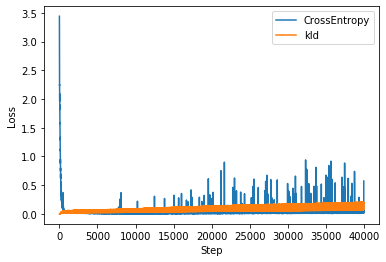

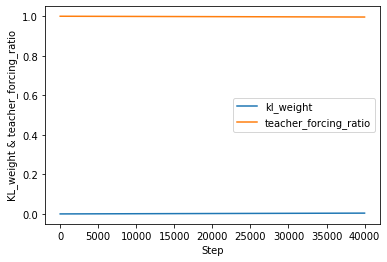

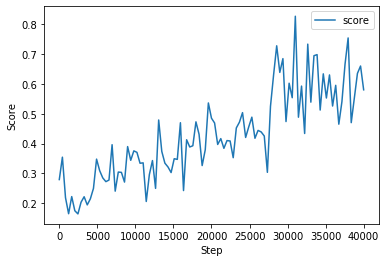

In [24]:
plt.figure()

load = True
if load:
    acc = np.load(loss_file)
    entropy = acc['entropy'][:40001]
    kld = acc['kld'][:40001]
    kl_weight = acc['kl_weight'][:40001]
    teacher_forcing_ratio = acc['teacher_forcing_ratio'][:40001]
    score = acc['score']
    score = score[:len(score)//2]
    
# plt.title("Activation Function comparision(EEGNet)")
plt.ylabel("Loss")
plt.xlabel("Step")
# print(test_loss)
x = np.arange(1, len(entropy)+1)
plt.plot(x, entropy, label="CrossEntropy")
plt.plot(x, kld, label="kld")
plt.legend()
plt.show()
plt.clf()

plt.ylabel("KL_weight & teacher_forcing_ratio")
plt.xlabel("Step")
# print(test_loss)
x = np.arange(1, len(kl_weight)+1)
plt.plot(x, kl_weight, label="kl_weight")
plt.plot(x, teacher_forcing_ratio, label="teacher_forcing_ratio")
# plt.plot(x, test_loss, label="test")
plt.legend()
plt.show()

plt.ylabel("Score")
plt.xlabel("Step")
# print(test_loss)
x = np.linspace(1, len(kl_weight)+1, len(score))
plt.plot(x, score, label="score")
# plt.plot(x, test_loss, label="test")
plt.legend()
plt.show()


In [13]:

def reparaterization_trick(mean, logv):
        std = torch.exp(0.5*logv)
        eps = torch.randn_like(std)
        return  mean + eps * std
    
def Gaussian_score(words):
    words_list = []
    score = 0
    yourpath = './train.txt'#should be your directory of train.txt
    with open(yourpath,'r') as fp:
        for line in fp:
            word = line.split(' ')
            word[3] = word[3].strip('\n')
            words_list.extend([word])
        for t in words:
            for i in words_list:
                if t == i:
                    score += 1
    return score/len(words)
    
label = torch.LongTensor([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]]).to(device)
words = []
for i in range(100):
    encoder_means = torch.randn([1, 1, 32]).to(device)
    encoder_logv = torch.randn([1, 1, 32]).to(device)
    encoder_hidden = reparaterization_trick(encoder_means, encoder_logv)
    encoder_hidden = decoder.latent2hidden(encoder_hidden)
    
    tmp = []
    for i in range(4):
        hidden = torch.cat([encoder_hidden, label[i].view(1, 1, 4)], dim=2)
        decoded_indices = decoder.evaluate(context_vector=hidden)
        results = []
        for indices in decoded_indices:
            results.append(train_loader.vocab.indices_to_sequence(indices))
        tmp.append(results[0])
    words.append(tmp)
print(words)
print(Gaussian_score(words))

[['occup', 'occupies', 'occupying', 'occupiled'], ['escape', 'escapes', 'espestaining', 'espesteed'], ['horeshib', 'horeshibits', 'horeshibing', 'horsewhipped'], ['expend', 'expends', 'expending', 'expended'], ['focuse', 'focuses', 'focuses', 'focusted'], ['defend', 'defies', 'defiring', 'defired'], ['s', 'suss', 'suugging', 'sussed'], ['elect', 'elects', 'electing', 'elected'], ['sport', 'sporticizes', 'sporting', 'sported'], ['yell', 'yellends', 'yelling', 'yembled'], ['contribute', 'contributes', 'contributing', 'contributed'], ['botshing', 'botshinks', 'botshing', 'botshin'], ['joydyy', 'joydydreaks', 'ommforrofing', 'joydydread'], ['collabe', 'collasts', 'collasting', 'collaborated'], ['select', 'selects', 'selecting', 'selected'], ['wiglease', 'wielles', 'wielling', 'wieladed'], ['sayi', 'sayin', 'saying', 'sayin'], ['devot', 'devotes', 'devoting', 'devoted'], ['catch', 'catches', 'catching', 'catched'], ['sprowl', 'splashes', 'sprowling', 'sprowled'], ['exclaim', 'exclaims', 'ex

In [14]:
total_score = 0.0
for i in range(len(test_src)):
    word = train_loader.vocab.indices_to_sequence(test_src[i])
    trg_true = train_loader.vocab.indices_to_sequence(test_trg[i])
    results = trainer.evaluate(word, test_c_src[i].view(1, -1), test_c_trg[i].view(1, -1))[0]
    score = trainer.compute_bleu(results, trg_true)
    print("Src_true: {:>12}".format(word), "\tTrg_true:{:>12}".format(trg_true), "\tPredict: {:>12}".format(results), "\tScore: {:>8.5f}".format(score))
    total_score += score
total_score /= len(test_src)
print(total_score)

Src_true:      abandon 	Trg_true:   abandoned 	Predict:    abandoned 	Score:  1.00000
Src_true:         abet 	Trg_true:    abetting 	Predict:   accounting 	Score:  0.27776
Src_true:        begin 	Trg_true:      begins 	Predict:      bestirs 	Score:  0.08307
Src_true:       expend 	Trg_true:     expends 	Predict:     receives 	Score:  0.03656
Src_true:         sent 	Trg_true:       sends 	Predict:        scans 	Score:  0.07071
Src_true:        split 	Trg_true:   splitting 	Predict:    supplying 	Score:  0.15620
Src_true:       flared 	Trg_true:       flare 	Predict:      flarate 	Score:  0.43472
Src_true:  functioning 	Trg_true:    function 	Predict:     function 	Score:  1.00000
Src_true:  functioning 	Trg_true:  functioned 	Predict:   functioned 	Score:  1.00000
Src_true:      healing 	Trg_true:       heals 	Predict:        hears 	Score:  0.28574
0.4344760200310298


In [15]:
torch.save(decoder, "gru_decoder.pt")